In [ ]:
# Import the required modules
import datetime
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.rcParams['font.size'] = 8
from skimage import img_as_float
from skimage import exposure
import plotly.graph_objects as go

import os
import glob
import random
from skimage import io # To preprocess the images
from distutils.file_util import copy_file
import seaborn as sns
import cv2
import keras
from keras.models import load_model
from keras import backend as K
import tensorflow as tf

from skimage.transform import rescale
from keras_preprocessing.image import ImageDataGenerator

import warnings
warnings.simplefilter('ignore')

In [ ]:
from google.colab import files
import zipfile

In [ ]:
from google.colab import drive

In [ ]:
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [ ]:
zip_ref = zipfile.ZipFile("/content/gdrive/My Drive/Colab Notebooks/COVID19_research/archive.zip", 'r')
zip_ref.extractall("/tmp")
zip_ref.close()

In [ ]:
! ls /tmp

COVID-19_Radiography_Dataset
dap_multiplexer.fa71f718fbae.root.log.INFO.20210912-131130.64
dap_multiplexer.INFO
debugger_2f6ho6cy1t
drivefs_ipc.0
drivefs_ipc.0_shell
initgoogle_syslog_dir.0
tmppao4awd6


In [ ]:
! ls /tmp/COVID-19_Radiography_Dataset/

 COVID			      Normal.metadata.xlsx
 COVID.metadata.xlsx	      README.md.txt
 Lung_Opacity		     'Viral Pneumonia'
 Lung_Opacity.metadata.xlsx  'Viral Pneumonia.metadata.xlsx'
 Normal


In [ ]:
DATASET_PATH = '/tmp/COVID-19_Radiography_Dataset'

In [ ]:
# We will divide the dataset into two classes
data_class = ['COVID', 'Normal']

In [ ]:
covid_positive_path = os.path.join(DATASET_PATH,data_class[0],'*')

In [ ]:
print(covid_positive_path)

/tmp/COVID-19_Radiography_Dataset/COVID/*


In [ ]:

#Just observing the images
#obs_path = os.path.join(covid_positive_path,'*.png')
#print(obs_path)
#data = glob.glob(obs_path)
#for file in data:
#  print(file)

Text(0.5, 1.0, 'COVID negative patient')

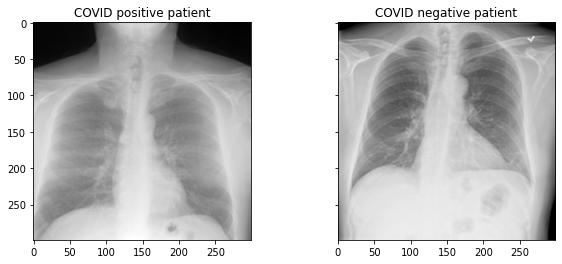

In [ ]:
covid = glob.glob(covid_positive_path)
covid = io.imread(covid[0])
#print(covid)
normal_path = os.path.join(DATASET_PATH,data_class[1],'*')
normal = glob.glob(normal_path)
normal = io.imread(normal[0],plugin='matplotlib')
fig,(ax1,ax2) = plt.subplots(1,2,sharey='all')
fig.set_figwidth(10)
ax1.imshow(covid, cmap='gray')
ax1.set_title('COVID positive patient')

ax2.imshow(normal, cmap='gray')
ax2.set_title('COVID negative patient')


# **Print shape of the images**

In [ ]:
print(f'Image shape:{covid.shape}')
print(f'Number of COVID positive images:{len(os.listdir(covid_positive_path[:-2]))}')
print(f'Number of COVID negative images:{len(os.listdir(normal_path[:-2]))}')

Image shape:(299, 299)
Number of COVID positive images:3616
Number of COVID negative images:10192


## **Preprocessing Images (Perfoeming Histogram Equalizatio)**

In [ ]:
def plot_img_and_hist(image, axes, bins=256):
  """Plot an image with its histogram and cumulutive histogram"""
  image = img_as_float(image)
  ax_img, ax_hist = axes
  print(axes.shape)
  ax_cdf = ax_hist.twinx()
  # Display image
  # Display image
  ax_img.imshow(image, cmap=plt.cm.gray)
  ax_img.set_axis_off()

  # Display histogram
  ax_hist.hist(image.ravel(), bins=bins, color='black')
  ax_hist.ticklabel_format(axis='y', style='scientific', scilimits=(0, 0))
  ax_hist.set_xlabel('Pixel intensity')
  ax_hist.set_xlim(0, 1)
  ax_hist.set_yticks([])

  # Display cumulative distribution
  img_cdf, bins = exposure.cumulative_distribution(image, bins)
  ax_cdf.plot(bins, img_cdf, 'r')
  ax_cdf.set_yticks([])

  return ax_img, ax_hist, ax_cdf


p2=7.0, p98 = 231.0
(2,)
(2,)
(2,)
(2,)


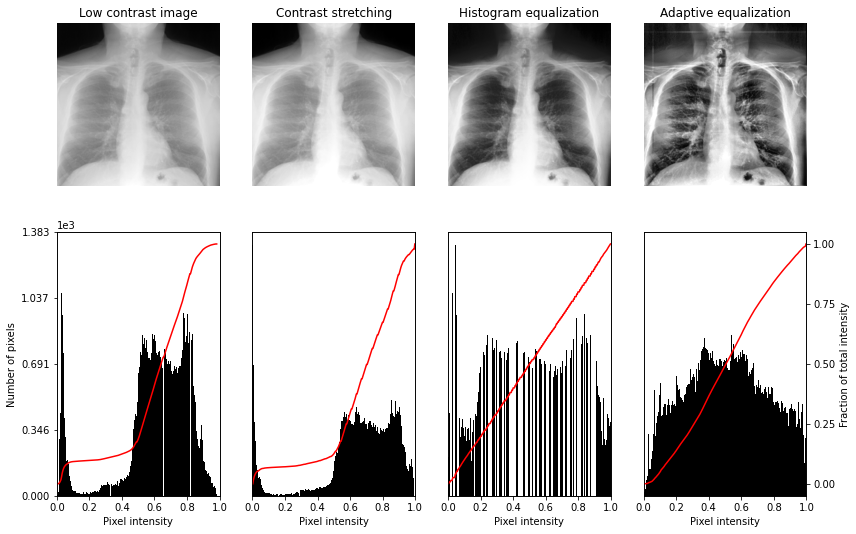

In [ ]:
# Loading the image here
#img = normal
img = covid
# Contrast stretching
p2, p98 = np.percentile(img,(2,98))
print(f'p2={p2}, p98 = {p98}')
img_rescale =exposure.rescale_intensity(img,(p2,p98))

# Equalization
img_eq = exposure.equalize_hist(img)

# Adaptive Equaliztion
img_adapteq = exposure.equalize_adapthist(img_eq, clip_limit=0.03)

#Display results
fig = plt.figure(figsize=(12,8))
axes = np.zeros((2,4), dtype=np.object)
#print(type(axes),axes.shape)
axes[0,0] = fig.add_subplot(2,4,1)

for i in range(1,4):
  axes[0,i] = fig.add_subplot(2,4,1+i, sharex=axes[0,0], sharey=axes[0,0])
for i in range(0,4):
  axes[1,i] = fig.add_subplot(2,4,5+i)

ax_img, ax_hist, ax_cdf = plot_img_and_hist(img, axes[:,0])
ax_img.set_title('Low contrast image')


y_min, y_max = ax_hist.get_ylim()
ax_hist.set_ylabel('Number of pixels')
ax_hist.set_yticks(np.linspace(0, y_max, 5))


ax_img, ax_hist, ax_cdf = plot_img_and_hist(img_rescale, axes[:, 1])
ax_img.set_title('Contrast stretching')

ax_img, ax_hist, ax_cdf = plot_img_and_hist(img_eq, axes[:, 2])
ax_img.set_title('Histogram equalization')

ax_img, ax_hist, ax_cdf = plot_img_and_hist(img_adapteq, axes[:, 3])
ax_img.set_title('Adaptive equalization')

ax_cdf.set_ylabel('Fraction of total intensity')
ax_cdf.set_yticks(np.linspace(0, 1, 5))

# prevent overlap of y-axis labels
fig.tight_layout()
plt.show()








## Creating train-test data

In [ ]:
# Create the list of paths to the images
Covid_Positive_List_Paths = []
Normal_List_Paths = []
# Get covid images files paths
for root, directories, files in os.walk(covid_positive_path[:-2]):
  for name in files:
    Covid_Positive_List_Paths.append(os.path.join(root,name))

for root, directories, files in os.walk(normal_path[:-2]):
  for name in files:
    Normal_List_Paths.append(os.path.join(root,name))
    

In [ ]:
random.shuffle(Covid_Positive_List_Paths)
random.shuffle(Normal_List_Paths)

## **Split the data**

In [ ]:
#main data folder
!mkdir ./Data/

#train data folders
!mkdir ./Data/Train/
!mkdir ./Data/Train/Covid/
!mkdir ./Data/Train/Normal/

#test data folders
!mkdir ./Data/Test/
!mkdir ./Data/Test/Covid/
!mkdir ./Data/Test/Normal/

PathCovidTrain = './Data/Train/Covid/'
PathCovidTest = './Data/Test/Covid/'

PathNormalTrain = './Data/Train/Normal/'
PathNormalTest = './Data/Test/Normal/'

num_covid = len(os.listdir(covid_positive_path[:-2]))
num_normal = len(os.listdir(normal_path[:-2]))

num_covid_train = round(len(os.listdir(covid_positive_path[:-2])) * 0.8)
num_normal_train = round(len(os.listdir(normal_path[:-2]))*0.8)

for i in range(num_covid):
  if i < num_covid_train:
    copy_file(Covid_Positive_List_Paths[i],PathCovidTrain)
  else:
    copy_file(Covid_Positive_List_Paths[i],PathCovidTest)

for i in range(num_normal):
  if i < num_normal_train:
    copy_file(Normal_List_Paths[i],PathNormalTrain)
  else:
    copy_file(Normal_List_Paths[i],PathNormalTest)


Defin the data generator

In [ ]:
# Definition of data generators

# For training data
trainGenerator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale = 1./255,
    rotation_range = 20,
    zoom_range = 0.2,
    shear_range = 0.2,
    featurewise_center =True,
    featurewise_std_normalization = True,
    width_shift_range = 0,
    vertical_flip = False,
    fill_mode = 'nearest'
) 
# Data for test
testGenerator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale = 1./255
)

# Build data generators

In [ ]:
# Bulild for train data
pathTrainDir = './Data/Train'
trainGeneratorBulid = trainGenerator.flow_from_directory(
    pathTrainDir,
    target_size = (299,299),
    class_mode = 'binary',
    batch_size = 16,
    shuffle =True
)

#Build for test data
pathTestDir = './Data/Test'
testGeneratorBuild = testGenerator.flow_from_directory(
    pathTestDir,
    target_size = (299,299),
    class_mode = 'binary',
    batch_size = 16,
    shuffle = True
)

Found 11047 images belonging to 2 classes.
Found 2761 images belonging to 2 classes.


In [ ]:
#Using sequential model:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(299, 299, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),

    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    
    tf.keras.layers.Conv2D(256, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 297, 297, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 148, 148, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 146, 146, 32)      9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 73, 73, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 71, 71, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 35, 35, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 33, 33, 128)       7

In [ ]:
# Define our custom loss function

def focal_loss(y_true, y_pred):
    gamma = 2.0
    alpha = 0.25
    pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))
    pt_0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))
    return -K.sum(alpha * K.pow(1. - pt_1, gamma) * K.log(pt_1))-K.sum((1-alpha) * K.pow( pt_0, gamma) * K.log(1. - pt_0))


# Compile our model
adam = tf.keras.optimizers.Adam(lr=0.0001)
model.compile(loss=[focal_loss], metrics=["accuracy"], optimizer=adam)


In [ ]:
start = datetime.datetime.now()

number_epochs = 25

history = model.fit(trainGeneratorBulid,
                    epochs = number_epochs, 
                    validation_data = testGeneratorBuild,
                    verbose = 1)

end = datetime.datetime.now()
print(f'Total Training Time: {end - start}')

Epoch 1/25
691/691 [==============================] - 287s 374ms/step - loss: 0.8584 - accuracy: 0.6891 - val_loss: 1.3872 - val_accuracy: 0.7925
Epoch 2/25
691/691 [==============================] - 261s 377ms/step - loss: 0.7063 - accuracy: 0.7639 - val_loss: 1.1060 - val_accuracy: 0.8855
Epoch 3/25
691/691 [==============================] - 262s 380ms/step - loss: 0.6368 - accuracy: 0.8022 - val_loss: 1.0223 - val_accuracy: 0.8022
Epoch 4/25
691/691 [==============================] - 261s 378ms/step - loss: 0.5861 - accuracy: 0.8184 - val_loss: 0.7966 - val_accuracy: 0.8932
Epoch 5/25
691/691 [==============================] - 261s 378ms/step - loss: 0.5144 - accuracy: 0.8483 - val_loss: 0.6363 - val_accuracy: 0.9160
Epoch 6/25
691/691 [==============================] - 261s 377ms/step - loss: 0.4753 - accuracy: 0.8590 - val_loss: 0.5990 - val_accuracy: 0.9210
Epoch 7/25
691/691 [==============================] - 260s 377ms/step - loss: 0.4471 - accuracy: 0.8711 - val_loss: 0.5729 -

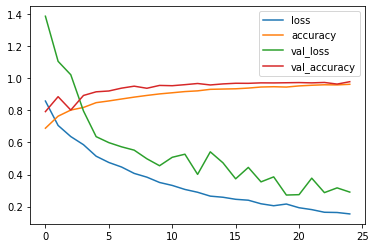

In [ ]:
pd.DataFrame(history.history).plot()

In [ ]:
model.save_weights('RegularCNN_results')

In [ ]:
! ls

checkpoint  gdrive				    RegularCNN_results.index
Data	    RegularCNN_results.data-00000-of-00001  sample_data


In [ ]:
from google.colab import files
files.download("RegularCNN_results.data-00000-of-00001")
#files.download(RegularCNN_results.index)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
files.download("RegularCNN_results.index")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Now we will use ResNET model

In [ ]:
base_model = tf.keras.applications.InceptionResNetV2(
    include_top = False,

    weights = 'imagenet',
    input_shape = (224,224,3),
    classifier_activation = 'sigmoid'
    
)

219070464/219055592 [==============================] - 2s 0us/step


Create a model

In [ ]:
x = tf.keras.layers.GlobalAveragePooling2D(name='avg_pool')(base_model.output)
out = tf.keras.layers.Dense(1, activation='sigmoid', name='dense_output')(x)
model_1 = tf.keras.models.Model(inputs = base_model.input, outputs=out)


1. Binary Cross_Entropy

In [ ]:
model_1.compile(
    optimizer = tf.keras.optimizers.Adam(0.001),
    loss = [focal_loss],
    metrics = ['accuracy']
)

In [ ]:
# Fit Keras model
start = datetime.datetime.now()

model_1_history = model_1.fit_generator(
    # Use train generator
    trainGeneratorBulid,

    # Set epochs to 10
    epochs = 10,

    # Set steps per epochs to 300
    steps_per_epoch = 300,
    
    # Set verbose to 1
    verbose = 1
)

end = datetime.datetime.now()
print(f'Total Training Time: {end - start}')

Epoch 1/10
300/300 [==============================] - 438s 1s/step - loss: 0.2092 - accuracy: 0.9596
Epoch 2/10
300/300 [==============================] - 418s 1s/step - loss: 0.1751 - accuracy: 0.9578
Epoch 3/10
300/300 [==============================] - 417s 1s/step - loss: 0.1725 - accuracy: 0.9628
Epoch 4/10
300/300 [==============================] - 418s 1s/step - loss: 0.1577 - accuracy: 0.9621
Epoch 5/10
300/300 [==============================] - 417s 1s/step - loss: 0.1339 - accuracy: 0.9662
Epoch 6/10
300/300 [==============================] - 417s 1s/step - loss: 0.1793 - accuracy: 0.9583
Epoch 7/10
300/300 [==============================] - 416s 1s/step - loss: 0.1631 - accuracy: 0.9614
Epoch 8/10
300/300 [==============================] - 416s 1s/step - loss: 0.1335 - accuracy: 0.9710
Epoch 9/10
300/300 [==============================] - 416s 1s/step - loss: 0.1366 - accuracy: 0.9672
Epoch 10/10
207/300 [===================>..........] - ETA: 2:08 - loss: 0.1438 - accuracy:

In [ ]:
model_1.summary()